# Kmeans Clustering

#### Loading packages and data

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 
import calendar
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from collections import Counter

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
import ast

import chart_studio
import chart_studio.plotly as py
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np

pd.options.mode.chained_assignment = None

In [282]:
plotly.__version__

'5.10.0'

In [256]:
species = pd.read_csv('all_species_112222.csv')
species.drop(species.columns[species.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

locations = pd.read_csv('locations_112222.csv')
locations.drop(locations.columns[locations.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# fixing NPSA coords
locations.loc[locations['Park Code'] == 'VIIS', 'Longitude'] = locations.loc[locations['Park Code'] == 'VIIS', 'Longitude']*-1

weather = pd.read_csv('NPS_weather_trends_112222.csv')

activities = pd.read_csv('activities.csv')
activities['cleaned'] = [ast.literal_eval(activities['cleaned'].iloc[i]) for i in range(len(activities))]

In [257]:
def regioncolors(counter):
    if counter['k_cluster'] == 0:
        return 'darkblue'
    elif counter['k_cluster'] == 1:
        return 'darkred'
    elif counter['k_cluster'] == 2:
        return 'blue'
    elif counter['k_cluster'] == 3:
        return 'darkgreen'
    else:
        return 'darkpurple'

In [258]:
class Cluster:
    def __init__(self, park, month, sim_or_diff):
        self.park = park
        self.month = month
        self.sim_or_diff = sim_or_diff

        self.weather_sp = []
        self.KM = KMeans(n_clusters = 5, random_state = 42)
        self.transform_weather()
        self.get_species_df()
        self.transform_species()
        self.combine_weather_sp()

    def transform_weather(self):
        '''Clean and scale weather data'''
        park_weather = weather[['ParkName', 'Month', 'Year', 'Temp_Avg_Fahrenheit', 'Prcp_Avg_Inches']]
        avg_10_yr = park_weather.groupby(['ParkName','Month']).agg('mean').reset_index().drop(columns = 'Year')
        avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
        avg_10_yr['month_name'] = avg_10_yr['month'].apply(lambda x: calendar.month_abbr[x])

        avg_10_yr = avg_10_yr[avg_10_yr['month_name'] == self.month]

        clus_temp = avg_10_yr[['temp', 'prcp']]
        self.X = StandardScaler().fit_transform(clus_temp)
        self.avg_10_yr = avg_10_yr

    def get_species_df(self):
        '''Return df of parks and list of species'''
        # sort park names for future merging
        temp_merged = self.avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')
        sort_parks = temp_merged['Park Code'].tolist()
        # new df with only species that are present 
        present_sp = species[species['Occurrence'] == 'Present']
        similarity_df = present_sp[['Park Name', 'Scientific Name', 'Park Code']]
        sort_i = dict(zip(sort_parks, range(len(sort_parks))))
        similarity_df['park_code_ranked'] = similarity_df['Park Code'].map(sort_i)
        similarity_df.sort_values(by = ['park_code_ranked'], inplace = True)
        similarity_df.drop('park_code_ranked', axis = 1, inplace = True)

        # list of all park codes
        park_codes = list(similarity_df['Park Code'].unique())
        # list of all species in a park
        code_sp_list = []
        for code in park_codes:
            sp = list(similarity_df[similarity_df['Park Code'] == code]['Scientific Name'])
            #sp.append(code)
            code_sp_list.append(sp)

        # new park-species dataframe
        park_sp_df = pd.DataFrame()
        park_sp_df['park_code'] = park_codes
        park_sp_df['species_list'] = code_sp_list
        self.park_sp_df = park_sp_df

    def transform_species(self):
        '''Transform species df'''
        # 0 if species is not present, 1 if species is present
        mlb = MultiLabelBinarizer()
        vec = mlb.fit_transform(self.park_sp_df['species_list'])
        vecs = pd.DataFrame(vec, columns=mlb.classes_)

        # apply cosine_similarity fxn on df
        df_cosine = pd.DataFrame(cosine_similarity(vecs,dense_output=True))

        # pca for dimensitonality reduction
        pca = PCA(n_components = 0.85)
        transform = pca.fit_transform(df_cosine)
        self.transform = transform

    def combine_weather_sp(self):
        '''Combine weather and species vecs'''
        # concat weather and species vecs
        for i in range(len(self.park_sp_df)):
            concat = np.concatenate((self.X[i], self.transform[i]))
            self.weather_sp.append(concat)
        self.weather_sp_arr = np.array(self.weather_sp)[:62]

    def kmeans(self):
        '''Perform K-means, return list of parks, map and silhouette score'''
        temp_labels = self.KM.fit_predict(self.weather_sp_arr)
        labs = np.unique(temp_labels)
        
        self.avg_10_yr['k_cluster'] = temp_labels
        temp_merged = self.avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')     
        temp_merged['color'] = temp_merged.apply(regioncolors, axis = 1)
        
        us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)
        location_list = temp_merged[['Latitude', 'Longitude']].values.tolist()
        park_names = temp_merged['Park Name'].tolist()  
        for point in range(0, len(location_list)):
            folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=temp_merged["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)
        #display(us_map)
        sil_score = silhouette_score(self.weather_sp_arr, self.KM.fit_predict(self.weather_sp_arr)) # a good silhouette score should be > 0.5

        user_cluster = temp_merged[temp_merged['park'] == self.park]['k_cluster'].item()
        
        if self.sim_or_diff == 'Similar':
            user_parks = temp_merged[temp_merged['k_cluster'] == user_cluster]['park'].tolist()
        elif self.sim_or_diff == 'Different':
            user_parks = temp_merged[temp_merged['k_cluster'] != user_cluster]['park'].tolist()
        return user_cluster, user_parks, sil_score
    

In [304]:
Cluster('Joshua Tree National Park', 'Jun', 'Similar').kmeans()[1]

['Black Canyon of the Gunnison National Park',
 'Bryce Canyon National Park',
 'Channel Islands National Park',
 'Grand Canyon National Park',
 'Great Basin National Park',
 'Great Sand Dunes National Park',
 'Haleakala National Park',
 'Hawaii Volcanoes National Park',
 'Joshua Tree National Park',
 'Kings Canyon National Park',
 'Lassen Volcanic National Park',
 'Mesa Verde National Park',
 'Pinnacles National Park',
 'Redwood National Park',
 'Rocky Mountain National Park',
 'Sequoia National Park',
 'Theodore Roosevelt National Park',
 'Yosemite National Park',
 'Zion National Park']

#### Silhouette Score Analysis

In [259]:
avg_10_yr = weather.groupby(['ParkName','Month']).agg('mean', numeric_only = True).reset_index().drop(columns = 'Year')
avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
avg_10_yr['month_name'] = avg_10_yr['month'].apply(lambda x: calendar.month_abbr[x])

In [260]:
sil_scores = [Cluster('Joshua Tree National Park', month, 'Similar').kmeans()[2] for month in avg_10_yr['month_name'].unique()]
print('Mean Silhouette Score:', np.mean(sil_scores))
month_score = dict(zip(avg_10_yr['month_name'].unique(),sil_scores))

# sorted by sil score
{k: v for k, v in sorted(month_score.items(), key=lambda item: item[1], reverse= True)}

Mean Silhouette Score: 0.30291177881989223


{'Oct': 0.3414578061837295,
 'Apr': 0.3164839609691635,
 'Nov': 0.31445045970685115,
 'Aug': 0.30965385258990147,
 'Mar': 0.30693793712184736,
 'Jan': 0.30626556557576357,
 'May': 0.3023829615631821,
 'Dec': 0.2956779471208909,
 'Feb': 0.29221756586415776,
 'Jun': 0.2859178674566252,
 'Jul': 0.28250737192049646,
 'Sep': 0.2809880497660971}

Text(0, 0.5, 'Silhouettte Score')

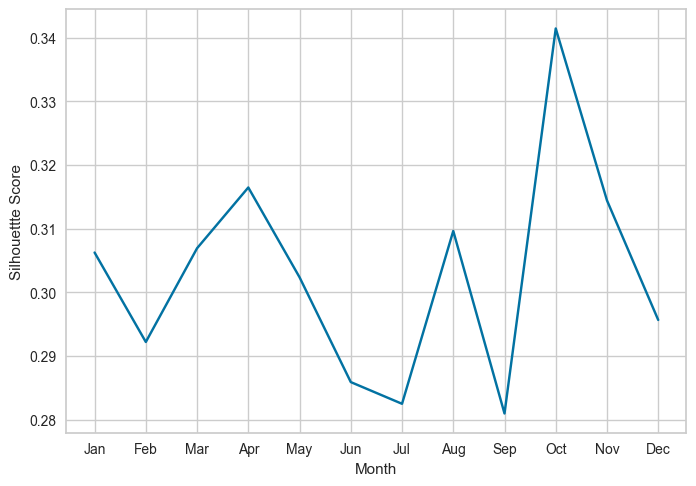

In [274]:
mn, sc = month_score.keys(), month_score.values()
plt.plot(mn, sc)
plt.xlabel('Month')
plt.ylabel('Silhouettte Score')

### Transform Species and Weather Data, Cluster

The cluster() function is same as Cluster() class; the function was used for Streamlit implementation.

In [262]:
def cluster(park, month, sim_or_diff):
    '''Input user park and month, return silhouette score, map, and parks in cluster'''
    
    park_weather = weather[['ParkName', 'Month', 'Year', 'Temp_Avg_Fahrenheit', 'Prcp_Avg_Inches']]

    # get 10-year averages for each month for each park
    avg_10_yr = park_weather.groupby(['ParkName','Month']).agg('mean').reset_index().drop(columns = 'Year')
    avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
    avg_10_yr['month_name'] = avg_10_yr['month'].apply(lambda x: calendar.month_abbr[x])
    avg_10_yr = avg_10_yr[avg_10_yr['month_name'] == month]

    clus_temp = avg_10_yr[['temp', 'prcp']]
    X = StandardScaler().fit_transform(clus_temp)

    # sort park names for future merging
    temp_merged = avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')
    sort_parks = temp_merged['Park Code'].tolist()
    # new df with only species that are present 
    present_sp = species[species['Occurrence'] == 'Present']
    similarity_df = present_sp[['Park Name', 'Scientific Name', 'Park Code']]
    sort_i = dict(zip(sort_parks, range(len(sort_parks))))
    similarity_df['park_code_ranked'] = similarity_df['Park Code'].map(sort_i)
    similarity_df.sort_values(by = ['park_code_ranked'], inplace = True)
    similarity_df.drop('park_code_ranked', axis = 1, inplace = True)

    # list of all park codes
    park_codes = list(similarity_df['Park Code'].unique())
    # list of all species in a park
    code_sp_list = []
    for code in park_codes:
        sp = list(similarity_df[similarity_df['Park Code'] == code]['Scientific Name'])
        #sp.append(code)
        code_sp_list.append(sp)

    # new park-species dataframe
    park_sp_df = pd.DataFrame()
    park_sp_df['park_code'] = park_codes
    park_sp_df['species_list'] = code_sp_list

    # 0 if species is not present, 1 if species is present
    mlb = MultiLabelBinarizer()
    vec = mlb.fit_transform(park_sp_df['species_list'])
    vecs = pd.DataFrame(vec, columns=mlb.classes_)

    # apply cosine_similarity fxn on df
    df_cosine = pd.DataFrame(cosine_similarity(vecs,dense_output=True))

    # pca for dimensitonality reduction
    pca = PCA(n_components =4)
    transform = pca.fit_transform(df_cosine)

    # concat weather and species vecs
    weather_sp = []
    for i in range(len(park_sp_df)):
        concat = np.concatenate((X[i], transform[i]))
        weather_sp.append(concat)
    weather_sp_arr = np.array(weather_sp)
    KM = KMeans(n_clusters = 5, random_state = 42)
    #model = KM.fit(X)
    temp_labels = KM.fit_predict(weather_sp_arr)

    labs = np.unique(temp_labels)
    avg_10_yr['k_cluster'] = temp_labels
    temp_merged = avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')

    location_list = temp_merged[['Latitude', 'Longitude']].values.tolist()
    park_names = temp_merged['Park Name'].tolist()

            
    temp_merged['color'] = temp_merged.apply(regioncolors, axis = 1)

    us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)

    for point in range(0, len(location_list)):
        folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=temp_merged["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)

    sil_score = silhouette_score(weather_sp_arr, KM.fit_predict(weather_sp_arr)) # a good silhouette score should be > 0.5
    print('Silhouette Score:', sil_score)
    user_cluster = temp_merged[temp_merged['park'] == park]['k_cluster'].item()
    user_parks = temp_merged[temp_merged['k_cluster'] == user_cluster]['park'].tolist()
    #display(us_map)
    if sim_or_diff == 'Similar':
        user_parks = temp_merged[temp_merged['k_cluster'] == user_cluster]['park'].tolist()
    elif sim_or_diff == 'Different':
        user_parks = temp_merged[temp_merged['k_cluster'] != user_cluster]['park'].tolist()
    return user_parks, weather_sp_arr

### Correlation Matrix

In [263]:
# connect to chart studio

chart_studio.tools.set_credentials_file(username='lching', api_key = 'kXp5arxg71xNaFmcXOSq')

In [264]:
weather_sp_array = cluster('Yosemite National Park', 'Mar', 'Similar')[1]

code_to_name_df = species[['Park Code', 'Park Name']].drop_duplicates()
code_to_name_dict = dict(zip(code_to_name_df['Park Code'], code_to_name_df['Park Name']))

corr = np.corrcoef(weather_sp_array)
#mask = np.triu(corr)
#np.fill_diagonal(mask, False)

df_corr = pd.DataFrame(corr, index = species['Park Name'].unique(), columns = species['Park Code'].unique())
names = list(code_to_name_dict.values())
X = np.repeat(names, len(df_corr.columns)).reshape(len(df_corr), len(df_corr))

fig = px.imshow(df_corr, labels = dict(x = 'Park 1', y = 'Park 2', color = 'Correlation'))
fig.update(data=[{'customdata': np.swapaxes(X, 0, 1), 
    'hovertemplate': 'Park 1: %{customdata}<br>Park 2: %{y}<br>Correlation: %{z}<extra></extra>'}])
fig.show()

Silhouette Score: 0.3407427780350563


In [265]:
#py.plot(fig, filename = 'corr_heatmap', auto_open=True)

### Filter Clustered Parks w/ Activities

In [290]:
# highlight most similar parks
def park_col(counter):
    '''Change color of park markers'''
    if counter['score'] == 3:
        return 'blue'
    elif counter['score'] == 2:
        return 'darkblue'
    elif counter['score'] == 1:
        return 'darkred'
    elif counter['score'] == 0:
        return 'darkgreen'

In [291]:
def highlight_col(x):
    '''Changes the color of park rows that match all 3 activities'''
    df = x.copy()
    #set by condition
    mask = df['score'] == 3
    df.loc[mask, :] = 'background-color: lightblue'
    df.loc[~mask,:] = 'background-color: ""'
    return df    

In [292]:
def activities_filter(lst_activities, lst_cluster, park):
    '''Input user activties, results from cluster fxn, user park, return final park map, activities df'''
    act_df = activities.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Code')[['park', 'Park Name','cleaned']]
    user_acts = act_df[act_df['Park Name'].isin(lst_cluster)]

    # rank parks based on count of user activities 
    scores = []
    for i in range(len(user_acts)):
        if len(set(lst_activities).intersection(set(user_acts['cleaned'].iloc[i]))) == 3:
            scores.append(3)
        elif len(set(lst_activities).intersection(set(user_acts['cleaned'].iloc[i]))) == 2:
            scores.append(2)
        elif len(set(lst_activities).intersection(set(user_acts['cleaned'].iloc[i]))) == 1:
            scores.append(1)
        else:
            scores.append(0)
    
    user_acts['score'] = scores
    sorted_acts = user_acts.sort_values(by = 'score', ascending = False)
    # if user park is in final filtered df, drop row
    sorted_acts = sorted_acts[sorted_acts['Park Name'].str.contains(park) == False]

    act_df = sorted_acts.iloc[:5]
    act_df.rename(columns = {'cleaned':'Activities'},inplace= True)
    act_df.reset_index(inplace = True, drop = True)

    act_loc_df = act_df.merge(locations, left_on = 'Park Name', right_on = 'Park Name')
    act_loc_df['color'] = act_loc_df.apply(park_col, axis = 1)
    

    location_list = act_loc_df[['Latitude', 'Longitude']].values.tolist()
    park_names = act_loc_df['Park Name'].tolist()

    # display final user map and final activities df
    result_map = folium.Map(tiles='CartoDB positron', zoom_start=14)
    for point in range(0, len(location_list)):
        folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=act_loc_df["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(result_map)
    display(result_map)
    
    act_df = act_df.style.apply(highlight_col, axis = None)
    return act_df


In [293]:
all_activities = [x for sublist in activities.cleaned.tolist()for x in sublist]

In [294]:
set(all_activities)

{'Backcountry Camping',
 'Backpacking',
 'Biking',
 'Bird Watching',
 'Boating',
 'Camping',
 'Canoeing/Kayaking',
 'Canyoneering',
 'Diving',
 'Fishing',
 'Hiking',
 'Horseback Riding',
 'Photography',
 'Rock Climbing',
 'Scenic Drives',
 'Skiing',
 'Snorkeling',
 'Stargazing',
 'Whale Watching',
 'Wildlife Viewing'}

In [295]:
locations['Park Name'].tolist()

['Acadia National Park',
 'Arches National Park',
 'Badlands National Park',
 'Big Bend National Park',
 'Biscayne National Park',
 'Black Canyon of the Gunnison National Park',
 'Bryce Canyon National Park',
 'Canyonlands National Park',
 'Capitol Reef National Park',
 'Carlsbad Caverns National Park',
 'Channel Islands National Park',
 'Congaree National Park',
 'Crater Lake National Park',
 'Cuyahoga Valley National Park',
 'Denali National Park',
 'Death Valley National Park',
 'Dry Tortugas National Park',
 'Everglades National Park',
 'Gates Of The Arctic National Park',
 'Glacier National Park',
 'Glacier Bay National Park',
 'Great Basin National Park',
 'Grand Canyon National Park',
 'Great Sand Dunes National Park',
 'Great Smoky Mountains National Park',
 'Grand Teton National Park',
 'Guadalupe Mountains National Park',
 'Haleakala National Park',
 'Hawaii Volcanoes National Park',
 'Hot Springs National Park',
 'Isle Royale National Park',
 'Joshua Tree National Park',
 'K

### Testing 

In [307]:
park_name = 'Yosemite National Park'
month = 'Jun'
sim_or_diff = 'Similar'
lst_activities = ['Fishing', 'Hiking', 'Photography']
clus_results = cluster(park_name, month, sim_or_diff)[0]

Silhouette Score: 0.3407326453458478


In [308]:
clus_results

['Black Canyon of the Gunnison National Park',
 'Bryce Canyon National Park',
 'Channel Islands National Park',
 'Grand Canyon National Park',
 'Great Basin National Park',
 'Great Sand Dunes National Park',
 'Haleakala National Park',
 'Hawaii Volcanoes National Park',
 'Joshua Tree National Park',
 'Kings Canyon National Park',
 'Lassen Volcanic National Park',
 'Mesa Verde National Park',
 'North Cascades National Park',
 'Pinnacles National Park',
 'Redwood National Park',
 'Rocky Mountain National Park',
 'Sequoia National Park',
 'Theodore Roosevelt National Park',
 'Wind Cave National Park',
 'Yosemite National Park',
 'Zion National Park']

### Insert function to filter high-attendance parks from clus_results here
- Input: a list of parks like clus_results, user answer (wants avoid crowded parks, doesn't mind crowded parks)
- Output: a filtered list of parks to pass through activities_filter()

In [309]:
activities_filter(lst_activities, clus_results, park_name)

,park,Park Name,Activities,score
0,ROMO,Rocky Mountain National Park,"['Fishing', 'Camping', 'Photography', 'Hiking', 'Wildlife Viewing']",3
1,GRSA,Great Sand Dunes National Park,"['Fishing', 'Horseback Riding', 'Stargazing', 'Backpacking', 'Photography', 'Hiking', 'Biking']",3
2,BLCA,Black Canyon of the Gunnison National Park,"['Fishing', 'Stargazing', 'Canyoneering', 'Scenic Drives', 'Hiking', 'Wildlife Viewing']",2
3,GRBA,Great Basin National Park,"['Fishing', 'Hiking']",2
4,GRCA,Grand Canyon National Park,"['Backcountry Camping', 'Stargazing', 'Canyoneering', 'Backpacking', 'Scenic Drives', 'Photography', 'Hiking', 'Wildlife Viewing', 'Biking']",2
